# Gurobi Setup



In [1]:
!pip install gurobipy  # install gurobipy, if not already installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 23.7 MB/s eta 0:00:00


In [1]:
import gurobipy as gp
import pandas as pd
import requests
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from gurobipy import GRB


In [7]:
state = "RI"
level = "census_tracts" #census_tracts or counties
params = {
#"WLSACCESSID": '',
#"WLSSECRET": '',
"LICENSEID": 2488807
}
env = gp.Env(params=params)

Set parameter Username
Set parameter LicenseID to value 2488807
Academic license - for non-commercial use only - expires 2025-03-14


#Download Data

In [39]:
state = "RI"
level = "census_tracts" #census_tracts or counties
base_url = 'https://lykhovyd.com/files/public/districting/2020/{}/{}/'.format(state, level)
filepath = '' #to save the files

if level == "counties":
  filename = state + "_counties"
elif level == "census_tracts":
  filename = state + "_tracts"


#Download shapefiles for map
url_maps = base_url + "maps/"
for fx in {'.shp', '.shx', '.dbf', '.prj', '.cpg'}:
  myfile = requests.get(url_maps+filename+fx, verify=False)
  open(filepath+filename+fx, 'wb').write(myfile.content)

#Download graph files
url_graph = base_url + "graph/"
for fx in {'.dimacs', '.hash', '.population', '_distances.csv'}:
  myfile = requests.get(url_graph+state+fx, verify=False)
  open(filepath+filename+fx, 'wb').write(myfile.content)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lykhovyd.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lykhovyd.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lykhovyd.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usa

In [40]:
## Helpers

def read_edges(filename):
  with open(filename, 'r') as file:
    edges = []
    for line in file:
      parts = line.strip().split()
      if parts[0] == 'e':
        edge = (int(parts[1]), int(parts[2]))
        edges.append(edge)
  return edges

def read_dists(filename):
    df = pd.read_csv(filename, index_col=0)
    return df.values.tolist()


def read_population(filename):
    with open(filename, 'r') as file:
        total_population = int(file.readline().strip().split('=')[-1])
        data = []
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                identifier, population = int(parts[0]), int(parts[1])
                data.append((identifier, population))
            else:
                print(f"Unexpected line format: {line}")
    return total_population, data

def read_geoids(filename):
  with open(filename, 'r') as file:
    data = []
    for line in file:
      parts = line.strip().split()
      if len(parts) == 2:
          identifier, population = int(parts[0]), int(parts[1])
          data.append((identifier, population))
      else:
          print(f"Unexpected line format: {line}")
  return  data


def read_num_districts(filename):
  with open(filename, 'r') as file:
    lines = [line for line in file]
  return  int(lines[-1][-2])


def draw_graph(Graph, node_size = 1100, node_label_font_size = 9, show_districts = False):

  total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
  ideal_population = total_population / k

  elarge = [(u, v) for (u, v, d) in G.edges(data=True)]

  pos = nx.spring_layout(G, seed=7, scale = 0.01)

  if show_districts:
    #obtain districts
    distrs = [G.nodes[i]['DISTR'] for i in range(len(G.nodes))]
    if distrs[0] is not None:
      # nodes
      nx.draw_networkx_nodes(G, pos, node_size=1100, node_color=distrs, cmap = 'tab20c')
    else:
      nx.draw_networkx_nodes(G, pos, node_size=1100)

  else:
    nx.draw_networkx_nodes(G, pos, node_size=1100)



  # edges
  nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5)

  pop_dict = {node:pop for node, pop in population}
  # node labels
  nx.draw_networkx_labels(G, pos, labels =pop_dict,  font_size=9, font_family="sans-serif")
  # edge weight labels
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)

  ax = plt.gca()
  ax.margins(0.08)
  plt.title("State: {}".format(state))
  plt.axis("off")
  plt.tight_layout()
  plt.show()


def draw_map(districts = None):
  # Load the Shapefile
  gdf = gpd.read_file('{}.shp'.format(filename))

  if districts is None:
    # Plot the Shapefile
    fig, ax = plt.subplots(figsize=(10, 10))
    my_fig = gdf.plot(ax=ax).get_figure()
    plt.show()


  else: #draw districts
    # Which district is each county assigned to?
    labeling = { i : -1 for i in G.nodes}

    for j in range(k):
        district = districts[j]
        for i in district:
            labeling[i] = j

    #Store district info in nodes
    for node in G.nodes:
      G.nodes[node]['DISTR'] = labeling[node]

    geoid_to_district = { G.nodes[i]['GEOID20'] : labeling[i] for i in G.nodes }

    assignments = []

    for i in range(len(gdf)):
      geoid = int(gdf['GEOID20'][i])
      assignments.append(geoid_to_district[geoid])

    gdf['assignment'] = assignments
    fig, ax = plt.subplots(figsize=(10, 10))
    my_fig = gdf.plot(column='assignment', ax= ax).get_figure()
    plt.show()




#Construct Graph object

In [41]:
#read files for graph
edges = read_edges('{}.dimacs'.format(filename))
total_population, population = read_population('{}.population'.format(filename))
geoids = read_geoids('{}.hash'.format(filename))

k = read_num_districts('{}.dimacs'.format(filename))  # desired number of districts
dists = read_dists('{}_distances.csv'.format(filename))
#populate graph
G=nx.Graph()

for (node, pop), (_, geoid) in zip(population, geoids):
  G.add_node(node, TOTPOP = pop, GEOID20 = geoid, DISTR = None)

#G.nodes gives a list of nodes
#for every node, node['TOTPOP'] gives population
#                node['GEOID20'] gives geoid20
#                node['DISTR'] gives assigned district
#edges are not weighted
#all distances are in dists
G.add_edges_from(edges)

#Initial Graph

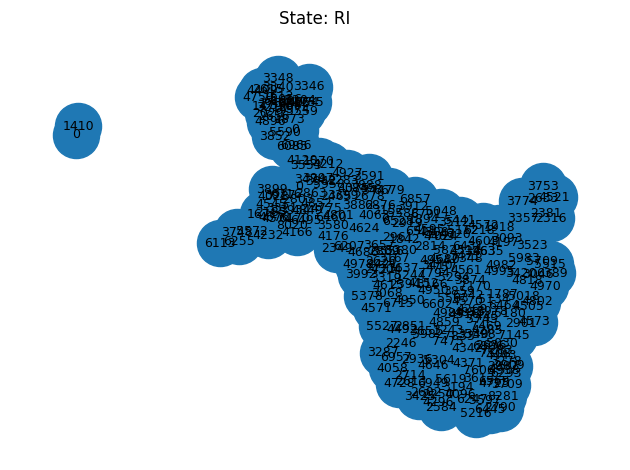

In [42]:
draw_graph(G)

#State Map

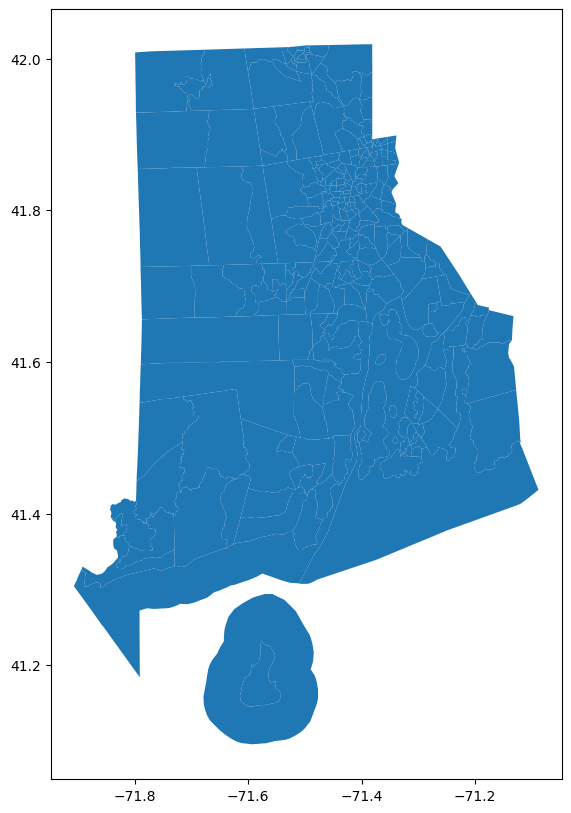

In [43]:
draw_map()

#Min Deviation model

###Model

In [12]:
# create model
m = gp.Model(env=env)
# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY )  # x[i,j] = 1 when county i is assigned to district j
y = m.addVar()                                 # y = population of smallest district
z = m.addVar()

In [13]:
# objective is to minimize absolute population deviation
m.setObjective( z - y, GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has population at least y
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= y for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= z for j in range(k) )

m.update()

In [14]:
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 21.4.0 21E230)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 254 rows, 502 columns and 1488 nonzeros
Model fingerprint: 0xb8ba3284
Variable types: 2 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 118917.00000
Presolve removed 250 rows and 256 columns
Presolve time: 0.01s
Presolved: 4 rows, 246 columns, 980 nonzeros
Variable types: 0 continuous, 246 integer (242 binary)
Found heuristic solution: objective 118915.00000

Root relaxation: objective 1.000000e+00, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

###Solution

In [15]:
# print the absolute population deviation
print("The minimum required deviation is",m.objVal,"persons.")

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("")

The minimum required deviation is 1.0 persons.
District 0 has these nodes = [3, 7, 8, 9, 10, 12, 13, 14, 16, 19, 21, 22, 24, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 49, 50, 52, 53, 55, 57, 59, 61, 63, 64, 65, 66, 68, 69, 72, 73, 77, 82, 87, 89, 91, 94, 96, 98, 100, 101, 103, 104, 106, 107, 109, 113, 114, 115, 118, 119, 120, 121, 123, 124, 125, 126, 129, 132, 134, 139, 140, 142, 144, 149, 150, 154, 155, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 177, 179, 181, 183, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 200, 202, 205, 209, 211, 214, 215, 216, 219, 220, 222, 225, 226, 228, 234, 236, 239, 243, 244, 246, 247] and this population = 548689

District 1 has these nodes = [0, 1, 2, 4, 5, 6, 11, 15, 17, 18, 20, 23, 25, 28, 33, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 54, 56, 58, 60, 62, 67, 70, 71, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 92, 93, 95, 97, 99, 102, 105, 108, 110, 111, 112, 116, 117, 122, 127, 128, 130, 131, 133, 135, 136, 137, 138, 141, 143

###Contiguity

In [16]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [3, 7, 8, 9, 10, 12, 13, 14, 16, 19, 21, 22, 24, 26, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 49, 50, 52, 53, 55, 57, 59, 61, 63, 64, 65, 66, 68, 69, 72, 73, 77, 82, 87, 89, 91, 94, 96, 98, 100, 101, 103, 104, 106, 107, 109, 113, 114, 115, 118, 119, 120, 121, 123, 124, 125, 126, 129, 132, 134, 139, 140, 142, 144, 149, 150, 154, 155, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 177, 179, 181, 183, 185, 186, 187, 188, 191, 192, 193, 194, 195, 196, 197, 200, 202, 205, 209, 211, 214, 215, 216, 219, 220, 222, 225, 226, 228, 234, 236, 239, 243, 244, 246, 247] connected? False
Is district = [0, 1, 2, 4, 5, 6, 11, 15, 17, 18, 20, 23, 25, 28, 33, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 54, 56, 58, 60, 62, 67, 70, 71, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 92, 93, 95, 97, 99, 102, 105, 108, 110, 111, 112, 116, 117, 122, 127, 128, 130, 131, 133, 135, 136, 137, 138, 141, 143, 145, 146, 147, 148, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 166, 170, 176

###Map

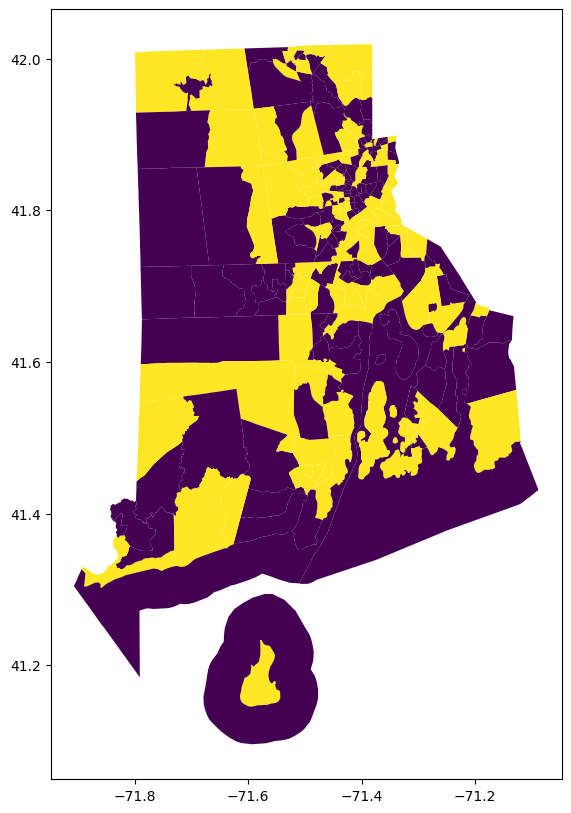

In [17]:
draw_map(districts = districts)


###Graph

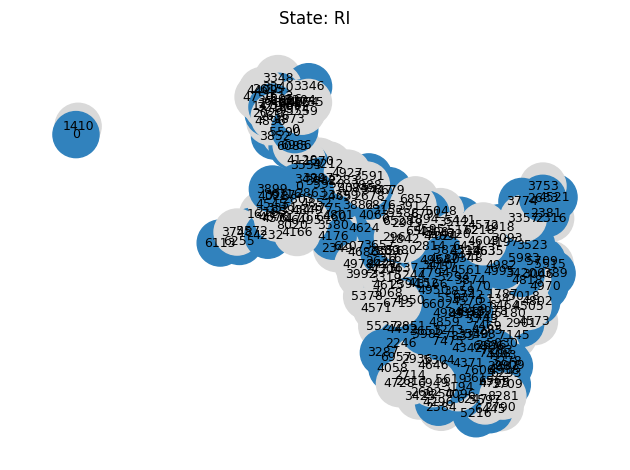

In [18]:
draw_graph(G, show_districts=True)

#Min Cut Edges

In [19]:
# Let's impose a 2% population deviation (+/-1%)
# (Usually, we use 1% deviation, but this instance is infeasible at 1%.)
deviation = 0.02

total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k

import math
L = math.ceil( ( 1 - deviation / 2 ) * ideal_population )
U = math.floor( ( 1 + deviation / 2 ) * ideal_population )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 543203 and U = 554176 and k = 2


###Model

In [20]:
# create model
m = gp.Model(env=env)

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY ) # x[i,j] = 1 if county i is assigned to district j
y = m.addVars( G.edges, vtype=GRB.BINARY )

# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

## Equivalently, we could write:
#m.setObjective( gp.quicksum( y ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [21]:
# solve IP model
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 21.4.0 21E230)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1590 rows, 1168 columns and 5492 nonzeros
Model fingerprint: 0xe211ada1
Variable types: 0 continuous, 1168 integer (1168 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 350.0000000
Presolve removed 254 rows and 252 columns
Presolve time: 0.01s
Presolved: 1336 rows, 916 columns, 4494 nonzeros
Variable types: 0 continuous, 916 integer (916 binary)
Found heuristic solution: objective 323.0000000

Root relaxation: objective 0.000000e+00, 341 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

###Solution

In [22]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )


The number of cut edges is 22.0
District 0 has these nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 86, 87, 89, 96, 97, 98, 114, 115, 120, 121, 129, 138, 143, 161, 162, 170, 181, 188, 197, 198, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 243] and this population = 547686
District 1 has these nodes = [41, 62, 63, 64, 65, 66, 67, 68, 78, 79, 80, 81, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,

##Contiguity

In [32]:
print(districts)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 86, 87, 89, 96, 97, 98, 114, 115, 120, 121, 129, 138, 143, 161, 162, 170, 181, 188, 197, 198, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 243], [41, 62, 63, 64, 65, 66, 67, 68, 78, 79, 80, 81, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 1

In [23]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 83, 84, 85, 86, 87, 89, 96, 97, 98, 114, 115, 120, 121, 129, 138, 143, 161, 162, 170, 181, 188, 197, 198, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 243] connected? True
Is district = [41, 62, 63, 64, 65, 66, 67, 68, 78, 79, 80, 81, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175,

##Map

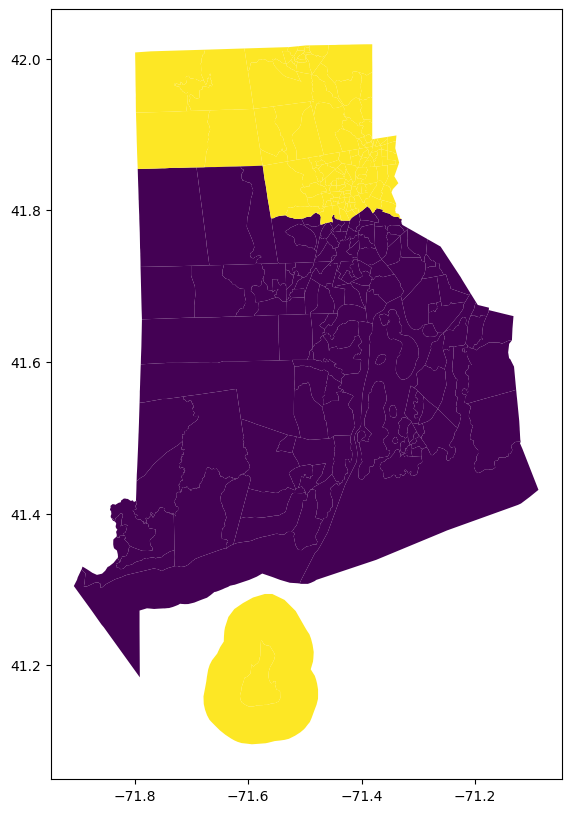

In [24]:
draw_map(districts = districts)


##Graph

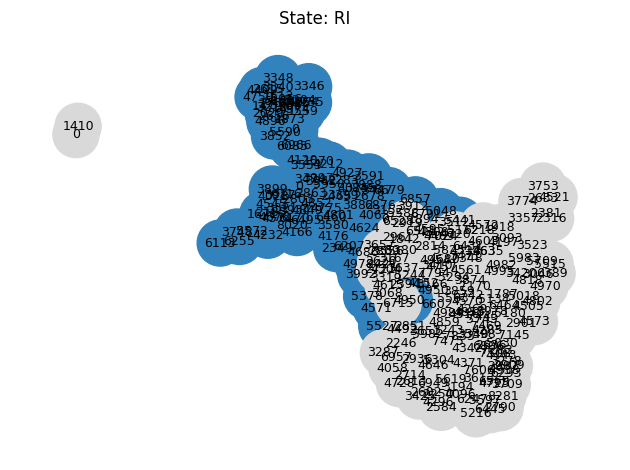

In [25]:
draw_graph(G, show_districts=True)

#Min Cut Edges with Contiguity


In [26]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02
import math
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 543203 and U = 554176 and k = 2


##Model

In [27]:
# create model
m = gp.Model(env = env)

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [28]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [29]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) )

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) )
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [30]:
# solve IP model
m.optimize()


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 21.4.0 21E230)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3010 rows, 3004 columns and 12168 nonzeros
Model fingerprint: 0x56654685
Variable types: 1336 continuous, 1668 integer (1668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 252 rows and 250 columns
Presolve time: 0.02s
Presolved: 2758 rows, 2754 columns, 11176 nonzeros
Variable types: 1336 continuous, 1418 integer (1418 binary)

Root relaxation: objective 0.000000e+00, 826 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  250          -    0.00000      -     -    0s
     0 

In [ ]:
# To solve the MIP faster, let's fix some district roots:

#r[6,0].LB = 1  # Fix Oklahoma County as root of district 0
#r[34,1].LB = 1 # Fix Tulsa County as root of district 1
#r[8,2].LB = 1  # Fix Comanche County as root of district 2

#m.reset()      # Force Gurobi to start solving 'from scratch'
#m.optimize()

##Solution

In [ ]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("")

##Contiguity

In [ ]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

##Map

In [ ]:
draw_map(districts = districts)

##Graph

In [ ]:
draw_graph(G, show_districts=True)

#Min Perimeter with Contiguity

In [111]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 543203 and U = 554176 and k = 2


##Model

In [113]:
# create model
m = gp.Model(env=env)

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

# objective is to minimize weighted cut edges (district perimeter lengths)
m.setObjective( gp.quicksum( dists[u][v] * y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()



In [114]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# To solve the MIP faster, fix some district roots:

#r[6,0].LB = 1  # fix Oklahoma county as root of district 0
#r[34,1].LB = 1 # fix Tulsa county as root of district 1
#r[8,2].LB = 1  # fix Comanche county as root of district 2

# Add flow variables: f[u,v] = amount of flow sent across arc uv
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )


# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) )

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) )
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [115]:
# solve IP model
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2492767 - for non-commercial use only - registered to n.___@student.tue.nl
Optimize a model with 3010 rows, 3004 columns and 12168 nonzeros
Model fingerprint: 0xdf661fc1
Variable types: 1336 continuous, 1668 integer (1668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve removed 252 rows and 250 columns
Presolve time: 0.05s
Presolved: 2758 rows, 2754 columns, 11176 nonzeros
Variable types: 1336 continuous, 1418 integer (1418 binary)

Root relaxation: objective 0.000000e+00, 783 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

##Solution

In [ ]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("")

The number of cut edges is 351990.0
District 0 has these nodes = [0, 1, 3, 6, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 27, 30, 31, 32, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 70, 71, 72, 73, 74, 75, 77, 79, 81, 82, 83, 85, 86, 87, 89, 90, 92, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 113, 116, 119, 121, 122, 123, 126, 127, 128, 131, 132, 133, 134, 135, 137, 140, 141, 143, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 158, 162, 163, 164, 167, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 190, 194, 195, 197, 198, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 211, 213, 214, 216, 217, 218, 219, 220, 221, 223, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 239, 240, 241, 242] and this population = 543214

District 1 has these nodes = [2, 4, 5, 8, 9, 10, 13, 15, 19, 24, 26, 28, 29, 33, 34, 35, 36, 38, 39, 40, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 76, 78, 80, 84, 88, 91, 9

##Contiguity

In [ ]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 3, 6, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 27, 30, 31, 32, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 70, 71, 72, 73, 74, 75, 77, 79, 81, 82, 83, 85, 86, 87, 89, 90, 92, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 113, 116, 119, 121, 122, 123, 126, 127, 128, 131, 132, 133, 134, 135, 137, 140, 141, 143, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 158, 162, 163, 164, 167, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 190, 194, 195, 197, 198, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 211, 213, 214, 216, 217, 218, 219, 220, 221, 223, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 239, 240, 241, 242] connected? True
Is district = [2, 4, 5, 8, 9, 10, 13, 15, 19, 24, 26, 28, 29, 33, 34, 35, 36, 38, 39, 40, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 76, 78, 80, 84, 88, 91, 93, 97, 98, 108, 111, 112, 114, 115, 117, 118, 120, 124, 125, 129, 130, 136, 138,

##Map

In [ ]:
draw_map(districts = districts)

##Graph

In [ ]:
draw_graph(G, show_districts=True)

#Min moment of inertia

In [116]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 543203 and U = 554176 and k = 2


##Model

In [117]:
# create model
m = gp.Model(env=env)

# create x[i,j] variable which equals one when county i
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dists[i][j]**2 * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()



In [118]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2492767 - for non-commercial use only - registered to n.___@student.tue.nl
Optimize a model with 63251 rows, 62500 columns and 310258 nonzeros
Model fingerprint: 0xd17439f3
Variable types: 0 continuous, 62500 integer (62500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+03, 6e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 250 rows and 0 columns
Presolve time: 2.01s
Presolved: 63001 rows, 62500 columns, 310258 nonzeros
Variable types: 0 continuous, 62500 integer (62500 binary)
Found heuristic solution: objective 3.823956e+08

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5677    8.2

##Solution

In [119]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("")

237631766.0
District 0 has these nodes = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 83, 84, 85, 86, 87, 89, 96, 97, 98, 114, 115, 121, 129, 138, 161, 162, 168, 170, 172, 181, 188, 197, 198, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 243] and this population = 543446

District 1 has these nodes = [7, 62, 63, 64, 65, 66, 67, 68, 78, 79, 80, 81, 82, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163

##Contiguity

In [120]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 83, 84, 85, 86, 87, 89, 96, 97, 98, 114, 115, 121, 129, 138, 161, 162, 168, 170, 172, 181, 188, 197, 198, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 243] connected? False
Is district = [7, 62, 63, 64, 65, 66, 67, 68, 78, 79, 80, 81, 82, 88, 90, 91, 92, 93, 94, 95, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 169, 171, 173, 174, 175, 176, 177

##Map

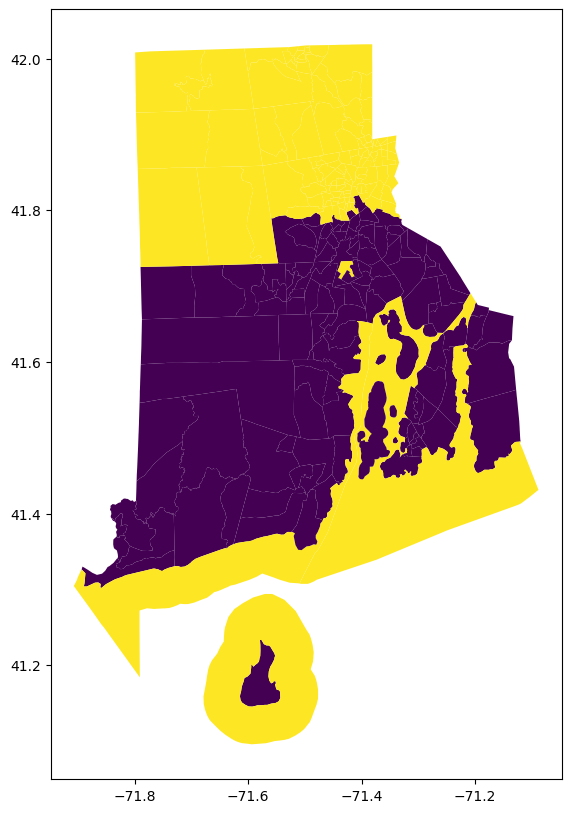

In [121]:
draw_map(districts = districts)

##Graph

In [ ]:
draw_graph(G, show_districts=True)

#Min moment of inertia with Contiguity

In [122]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.02

import math
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 543203 and U = 554176 and k = 2


##Model

In [123]:
# create model
m = gp.Model(env=env)

# create x[i,j] variable which equals one when county i
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dists[i][j] **2 * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [124]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [125]:
# add contiguity constraints
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars( DG.edges, G.nodes )

# add constraints saying that if node i is assigned to node j,
#   then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [ ]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2492767 - for non-commercial use only - registered to n.___@student.tue.nl
Optimize a model with 188001 rows, 396500 columns and 1434086 nonzeros
Model fingerprint: 0x645d4ec0
Variable types: 334000 continuous, 62500 integer (62500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+03, 6e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 2492 rows and 2829 columns (presolve time = 5s) ...
Presolve removed 2493 rows and 2829 columns (presolve time = 10s) ...
Presolve removed 2493 rows and 2829 columns
Presolve time: 12.72s
Presolved: 185508 rows, 393671 columns, 1425188 nonzeros
Variable types: 331669 continuous, 62002 integer (6200

##Solution

In [ ]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("")

##Contiguity

In [ ]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

##Map

In [ ]:
draw_map(districts = districts)

##Graph

In [ ]:
draw_graph(G, show_districts=True)